# Investigating which areas show significant second level effects at which times

In [1]:
%matplotlib notebook
import numpy as np
import helpers
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import source_visualisations as sv
import source_statistics as ss
import mne

## Data preparation
Which data?

In [2]:
# baseline [-0.3, 0], trialregs_dot=5
# basefile = 'source_HCPMMP1_allsubs_201703301614.h5'

# baseline None, trialregs_dot=5
#basefile = 'source_HCPMMP1_allsubs_201706091054.h5'

# baseline (-0.3, 0), trialregs_dot=5, GLM in source space
#basefile = 'source_sequential_201706141650.h5'

# baseline (-0.3, 0), trialregs_dot=5, GLM in source space, move_dist, sum_dot_y
#basefile = 'source_sequential_201706191442.h5'

# baseline (-0.3, 0), trialregs_dot=5, GLM in source space, move_dist, 
# sum_dot_y, constregs=0 for 1st dot
#basefile = 'source_sequential_201706201654.h5'

# baseline (-0.3, 0), only first 3 dots, trialregs_dot=3, GLM in source space, move_dist, 
# sum_dot_y, constregs=0 for 1st dot
#basefile = 'source_sequential_201706261151.h5'

# label mode = (abs)max, baseline (-0.3, 0), only first 3 dots, trialregs_dot=3, GLM in source space, 
# move_dist, sum_dot_y, constregs=0 for 1st dot
#basefile = 'source_sequential_201706281100.h5'

# baseline (-0.3, 0), only first 3 dots, trialregs_dot=3, move_dist, 
# sum_dot_y, constregs=0 for 1st dot, 
# label_tc normalised across trials, times and subjects
#basefile = 'source_sequential_201707031206.h5'

# label mode = mean, baseline (-0.3, 0), only first 3 dots, 
# trialregs_dot=3, source GLM, move_dist, sum_dot_y, constregs=0 for 1st dot, 
# label_tc normalised across trials, times and subjects
#basefile = 'source_sequential_201708241011.h5'

# label mode = mean, baseline (-0.3, 0), only first 3 dots, 
# trialregs_dot=0, source GLM, sum_dot_y, motoprep, constregs=0 for 1st dot, 
# subject-specific normalisation of DM without centering and scaling by std
# label_tc normalised across trials, times and subjects
basefile = 'source_sequential_201709011758.h5'

choose measure and identify threshold

In [3]:
# e.g.: mu_p_large, mu_testval, mu_t, mu_mean
#measure = 'mu_mean'
measure = 'mu_p_large'

# which regressors should define the empirical value distribution?
# set regressors = None for all
#regressors = ['accev', 'dot_x', 'dot_y', 'abs_dot_x', 'abs_dot_y']
regressors = ['motoprep', 'response', 'trial_time', 'entropy']

# do not use these regressors to define empirical value distribution
#exclude = 'trialregs'
#exclude = 'dotregs'

# the empiric error threshold for a single time point and area
# (the selected threshold will be the quantile 1-alpha of the 
# empirical distribution of measure values)
alpha = 0.05

threshold, measure_cdf = ss.find_slabs_threshold(
    basefile, measure, quantile=1-alpha, regressors=regressors, 
    verbose=1, return_cdf=True)

print('\nthreshold = {:.4f}'.format(threshold))

adding motoprep
adding response
adding trial_time
adding entropy
N = 101360

threshold = 0.8070


what are large values for the possible measures (used for setting y-lim in plotting)

In [4]:
ylims = {'mu_p_large': 1, 'mu_t': 8, 'mu_z': 8, 'mu_testval': 0.02, 'mu_mean': 0.04}
logy = {'mu_p_large': False, 'mu_t': False, 'mu_z': False, 'mu_testval': True, 'mu_mean': False}

## Load data for all selected regressors and identify significant clusters in time
The idea is that you identify sequences of high measure values that cannot happen by chance. This is all based on the empirical measure distribution used above. This distribution defines the probability with which I would get a particular measure value, if I were to draw one randomly across locations, time points and regressors. So it is a permutation distribution. I then use the cumulative density function of this distribution to first select a cluster threshold, i.e., a measure value which has to be exceeded in order to form a sequence cluster. Then I identify clusters, i.e., sequences of measure values within an area that exceed the threshold. The p-value of the found cluster is the product of 1-cdf(value) for the measure values in the sequence.

In [5]:
clusters = ss.get_fdrcorr_clusters(basefile, regressors, measure, threshold, measure_cdf,
                                   fdr_alpha=0.001)

print('cluster counts:')
print(clusters.label.groupby(level='regressor').count())

clusters.sort_values('start_t').sort_index(level='regressor', sort_remaining=False)

cluster counts:
regressor
motoprep      304
response       78
trial_time    260
entropy        13
Name: label, dtype: int64


label  start_t  end_t     log10p  pval_corrected  \
regressor  cluster                                                              
motoprep   577         R_EC_ROI-rh        0     40  -7.974979    1.151800e-07   
           148        L_FST_ROI-lh        0     80 -16.758410    7.068667e-16   
           434        R_13l_ROI-rh        0     20  -5.586145    1.570787e-05   
           157        L_IP0_ROI-lh        0     10  -3.602604    8.696131e-04   
           693       R_PHA1_ROI-rh        0     30  -7.760767    1.790150e-07   
           173        L_LO1_ROI-lh        0     20  -5.394607    2.358185e-05   
           177        L_LO3_ROI-lh        0     80 -20.300524    2.789497e-19   
           696       R_PHA2_ROI-rh        0     30  -6.732450    1.528610e-06   
           824         R_V7_ROI-rh        0     30  -6.006772    6.711040e-06   
           397        L_p24_ROI-lh        0     50  -9.042400    1.247945e-08   
           185        L_MIP_ROI-lh        0     40  -8.177242    7.537214e-08   
           393      L_d23ab_ROI-lh        0     20  -4.806645    7.646346e-05   
           806       R_V3CD_ROI-rh        0     30  -7.164864    6.353818e-07   
           208        L_OP4_ROI-lh        0     30  -7.302201    4.790946e-07   
           362        L_V6A_ROI-lh        0     30  -6.817422    1.290425e-06   
           361        L_V4t_ROI-lh        0     20  -4.644148    1.045002e-04   
           356       L_V3CD_ROI-lh        0     10  -3.669123    7.582613e-04   
           224        L_PGi_ROI-lh        0     10  -3.845799    5.343110e-04   
           308       L_TE1a_ROI-lh        0     20  -4.823472    7.437483e-05   
           316       L_TE2a_ROI-lh        0     20  -5.334974    2.677165e-05   
           326        L_TGv_ROI-lh        0     20  -4.783451    7.943586e-05   
           780         R_TF_ROI-rh        0     20  -5.523119    1.796163e-05   
           268       L_PoI1_ROI-lh        0     30  -7.240047    5.504359e-07   
           720       R_PreS_ROI-rh        0     20  -5.322589    2.740375e-05   
           129         L_EC_ROI-lh        0     20  -6.121490    5.298994e-06   
           336      L_TPOJ1_ROI-lh        0     20  -5.118535    4.060326e-05   
           339      L_TPOJ2_ROI-lh        0     10  -3.674064    7.529709e-04   
           340      L_TPOJ3_ROI-lh        0     10  -4.141432    2.905150e-04   
           241       L_PHA3_ROI-lh        0     20  -5.707471    1.227975e-05   
           713       R_PeEc_ROI-rh        0     20  -5.272503    3.028407e-05   
...                            ...      ...    ...        ...             ...   
trial_time 707        R_V3B_ROI-rh      630    650  -4.204843    2.537972e-04   
           317       L_VMV1_ROI-lh      630    690 -11.259189    1.067145e-10   
           479         R_7m_ROI-rh      640    680  -7.123358    6.962017e-07   
           629        R_PHT_ROI-rh      640    690  -9.028260    1.281334e-08   
           264      L_STSdp_ROI-lh      640    670  -6.112999    5.386668e-06   
           735        R_VVC_ROI-rh      640    690 -10.684458    3.629515e-10   
           674       R_TE1p_ROI-rh      640    690 -10.553125    4.797794e-10   
           665      R_STSvp_ROI-rh      650    690  -8.321120    5.751993e-08   
           6                ???-rh      650    680  -7.547409    2.864661e-07   
           577       R_IPS1_ROI-rh      650    680  -5.820033    9.835188e-06   
           187        L_PGi_ROI-lh      650    690  -7.847191    1.494801e-07   
           621        R_PGs_ROI-rh      650    670  -4.391862    1.712433e-04   
           83         L_8Av_ROI-lh      660    690  -5.551236    1.693060e-05   
           17         L_13l_ROI-lh      670    690  -5.001829    5.222664e-05   
           454         R_52_ROI-rh      670    690  -4.978653    5.470324e-05   
           250       L_ProS_ROI-lh      670    690  -4.577570    1.191063e-04   
           133       L_IFJa_ROI-lh      680    690  -3.84017

## Find all clusters of a given area or region

In [7]:
area = 'v23ab'
clusters[clusters.label.apply(lambda s: s.find(area) >= 0)]

label  start_t  end_t     log10p  pval_corrected  \
regressor cluster                                                              
accev     516      L_v23ab_ROI-lh       50    440 -84.896615    9.668077e-83   
          1084     R_v23ab_ROI-rh       40    450 -94.620351    7.305735e-92   
dot_x     382      L_v23ab_ROI-lh      110    130  -6.504160    3.458962e-06   
          383      L_v23ab_ROI-lh      150    190 -11.076668    1.950184e-10   
          384      L_v23ab_ROI-lh      300    490 -51.541657    3.502817e-50   
          747      R_v23ab_ROI-rh      110    120  -4.476397    2.207585e-04   
          748      R_v23ab_ROI-rh      150    200 -12.001178    2.512187e-11   
          749      R_v23ab_ROI-rh      300    490 -57.797886    2.311581e-56   

                                       region  
regressor cluster                              
accev     516      posterior cingulate cortex  
          1084     posterior cingulate cortex  
dot_x     382      posterior cingulate cortex  
          383      posterior cingulate cortex  
          384      posterior cingulate cortex  
          747      posterior cingulate cortex  
          748      posterior cingulate cortex  
          749      posterior cingulate cortex

In [8]:
region = 'frontal'
clusters[clusters.region.apply(lambda s: s.find(region) >= 0)]

label  start_t  end_t     log10p  pval_corrected  \
regressor cluster                                                              
accev     7          L_10r_ROI-lh      560    580  -4.762206    1.242919e-04   
          12         L_10v_ROI-lh      460    480  -4.814143    1.137707e-04   
          14         L_10v_ROI-lh      560    580  -5.258838    4.526926e-05   
          44          L_25_ROI-lh      440    470  -6.270397    5.415157e-06   
          46          L_25_ROI-lh      530    570  -9.594306    4.645072e-09   
          47          L_25_ROI-lh      650    670  -4.714587    1.349181e-04   
          69        L_33pr_ROI-lh      200    450 -55.565895    3.450714e-54   
          70        L_33pr_ROI-lh      470    490  -4.849118    1.059991e-04   
          81          L_44_ROI-lh      110    120  -3.952338    6.604948e-04   
          152        L_8Ad_ROI-lh      220    260  -8.475903    5.198233e-08   
          153        L_8Ad_ROI-lh      330    350  -4.796807    1.167003e-04   
          161        L_8BM_ROI-lh      310    370 -11.282586    1.223167e-10   
          163        L_8BM_ROI-lh      410    440  -6.700739    2.335086e-06   
          176        L_AVI_ROI-lh      440    490  -9.483119    5.860033e-09   
          178        L_AVI_ROI-lh      540    570  -6.375536    4.411492e-06   
          213       L_IFJa_ROI-lh      200    230  -6.527561    3.313536e-06   
          217       L_IFJp_ROI-lh      200    220  -4.251844    3.461975e-04   
          220       L_IFSp_ROI-lh      100    130  -6.225732    5.942694e-06   
          241         L_Ig_ROI-lh      320    340  -4.410805    2.499625e-04   
          318         L_PI_ROI-lh       30     40  -3.928854    6.935843e-04   
          334        L_Pir_ROI-lh      430    450  -4.428501    2.422931e-04   
          357        L_SFL_ROI-lh      270    290  -4.494365    2.136650e-04   
          358        L_SFL_ROI-lh      370    380  -3.881641    7.668370e-04   
          454        L_a24_ROI-lh      460    490  -5.770121    1.508691e-05   
          460      L_a24pr_ROI-lh      320    350  -6.438788    3.866739e-06   
          462      L_a24pr_ROI-lh      420    440  -5.334381    3.824791e-05   
          466      L_a32pr_ROI-lh      330    350  -4.226570    3.632580e-04   
          467      L_a32pr_ROI-lh      370    390  -5.748660    1.575927e-05   
          468      L_a32pr_ROI-lh      420    440  -4.683697    1.444896e-04   
          469      L_a32pr_ROI-lh      480    510  -6.474896    3.647212e-06   
...                           ...      ...    ...        ...             ...   
          1062     R_p32pr_ROI-rh      290    410 -23.442634    1.803231e-22   
          1078       R_s32_ROI-rh      450    490  -9.171654    1.159812e-08   
          1079       R_s32_ROI-rh      540    580  -8.056048    1.257731e-07   
          1080       R_s32_ROI-rh      640    680  -8.647417    3.538317e-08   
          1082      R_s6-8_ROI-rh      200    220  -5.572685    2.303174e-05   
          1083      R_s6-8_ROI-rh      330    380 -10.067298    1.740307e-09   
dot_x     38        L_33pr_ROI-lh      290    340 -11.059283    2.014456e-10   
          39        L_33pr_ROI-lh      370    500 -28.221014    3.523693e-27   
          114        L_8BM_ROI-lh      340    350  -4.127100    4.531179e-04   
          145       L_IFJa_ROI-lh      410    430  -4.223614    3.642760e-04   
          269        L_SFL_ROI-lh      460    490  -6.881060    1.603300e-06   
          360      L_a32pr_ROI-lh      300    320  -4.249499    3.473675e-04   
          368      L_p24pr_ROI-lh      450    480  -6.461322    3.715103e-06   
          372      L_p32pr_ROI-lh      300    320  -4.344688    2.877340e-04   
          373      L_p32pr_ROI-lh      430    490 -10.771311    3.712698e-10   
          418       R_33pr_ROI-rh      290    320  -5.925417    1.096690e-05   
          419       R_33pr_ROI-rh      370    400  -6.357012    4.559281e-06   
          420       R_33pr_R

## Investigate individual regressors

In [14]:
r_name = 'motoprep'
#r_name = 'trial_time'
r_clusters = clusters.xs(r_name, level='regressor').copy()

src_df = ss.load_src_df(basefile, r_name)

In [17]:
src_df_masked = ss.load_src_df?

In [23]:
src_df_masked = ss.load_src_df(basefile, r_name)

In [24]:
src_df_masked.mu_mean.reset_index('label').pivot(columns='label')

mu_mean                                                    \
label    ???-lh    ???-rh L_10d_ROI-lh L_10pp_ROI-lh L_10r_ROI-lh   
time                                                                
0      0.043901  0.034538     0.046118      0.053425     0.038276   
10     0.361928  0.086091     0.243153      0.284743     0.124399   
20     0.213201  0.083428     0.123182      0.127035     0.041220   
30     0.059133  0.040350     0.055692      0.071923     0.037995   
40     0.035101  0.035025     0.073773      0.066980     0.049376   
50     0.049290  0.035809     0.036917      0.046169     0.047343   
60     0.034262  0.039269     0.042352      0.046851     0.045065   
70     0.042730  0.039907     0.047408      0.054914     0.054107   
80     0.044111  0.029706     0.036830      0.061747     0.050120   
90     0.047772  0.034577     0.023789      0.033627     0.030807   
100    0.046184  0.034683     0.026082      0.028491     0.025285   
110    0.037385  0.034176     0.025445      0.041750     0.028944   
120    0.038501  0.031341     0.032150      0.046295     0.033194   
130    0.041077  0.036144     0.029340      0.031452     0.035924   
140    0.030111  0.026360     0.028648      0.026365     0.024979   
150    0.022315  0.024090     0.024871      0.022123     0.024837   
160    0.027752  0.019909     0.027920      0.026355     0.040487   
170    0.044810  0.024622     0.041862      0.028945     0.050647   
180    0.031636  0.023768     0.029545      0.029598     0.034930   
190    0.027726  0.017292     0.021508      0.018029     0.022535   
200    0.025593  0.023760     0.019832      0.017590     0.019717   
210    0.027670  0.023283     0.015737      0.021413     0.024630   
220    0.022691  0.024725     0.024444      0.023799     0.023832   
230    0.020723  0.024108     0.021680      0.025641     0.024800   
240    0.019365  0.018273     0.019271      0.015681     0.019925   
250    0.021162  0.021679     0.020982      0.014718     0.021996   
260    0.029208  0.023292     0.024802      0.019786     0.026219   
270    0.031069  0.022070     0.025758      0.016965     0.026629   
280    0.024099  0.022489     0.026447      0.021190     0.027361   
290    0.017399  0.018288     0.024366      0.016122     0.026014   
...         ...       ...          ...           ...          ...   
400    0.023201  0.019349     0.017166      0.011343     0.011267   
410    0.019979  0.015638     0.014378      0.011207     0.013302   
420    0.013939  0.012468     0.015386      0.010825     0.012561   
430    0.021090  0.013862     0.020813      0.010275     0.014713   
440    0.018315  0.019305     0.021478      0.011221     0.017835   
450    0.013177  0.013399     0.019479      0.008712     0.014221   
460    0.018260  0.011599     0.013554      0.010390     0.012890   
470    0.019091  0.013091     0.013882      0.009427     0.012818   
480    0.020964  0.018821     0.013130      0.015715     0.012580   
490    0.017898  0.019731     0.015208      0.011592     0.009570   
500    0.016831  0.012509     0.017905      0.012900     0.010037   
510    0.023741  0.016307     0.013352      0.012668     0.011930   
520    0.021059  0.013597     0.015151      0.011906     0.011290   
530    0.021758  0.012565     0.020514      0.010477     0.011414   
540    0.021979  0.017359     0.019236      0.008118     0.009837   
550    0.017109  0.017975     0.017085      0.007931     0.009259   
560    0.023389  0.014885     0.015810      0.010883     0.008755   
570    0.022237  0.017609     0.014464      0.010584     0.009694   
580    0.020795  0.015211     0.012762      0.013341     0.008774   
590    0.016621  0.017956     0.014260      0.014263     0.009396   
600    0.015541  0.018398     0.012762      0.013468     0.010791   
610    0.020899  0.013369     0.009921      0.010512     0.008737   
620    0.024415  0.014109     0.012237      0.010239     0.009318   
630    0.024008  0.015096     0.013511      0.008242     0.009730   
640   

### Check the times at which we see significant clusters

<IPython.core.display.Javascript object>


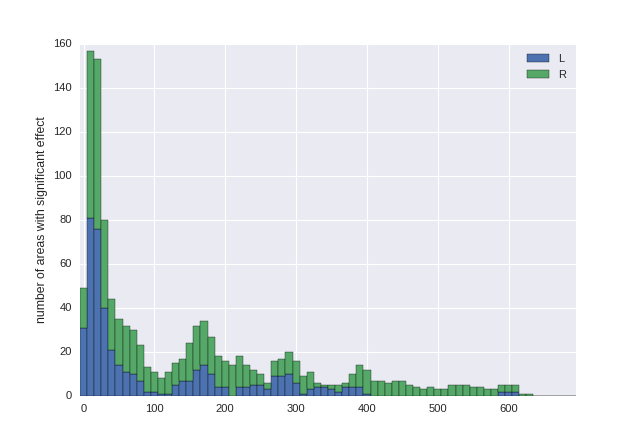

In [15]:
times = src_df[measure].index.levels[1]
sigareas = r_clusters.label.unique()
significant = pd.DataFrame(np.zeros((sigareas.size, times.size), bool), 
                           index=sigareas, columns=times)
for row in r_clusters.itertuples():
    significant.loc[row.label, slice(row.start_t, row.end_t)] = True
    
fig, ax = plt.subplots()
left = significant.columns - 5
colors = plt.rcParams['axes.prop_cycle']._left

# plot left hemi 
numlh = significant[significant.index.map(lambda l: l[0]) == 'L'].sum()
ax.bar(left, height=numlh, width=10, bottom=0, color=colors[0]['color'])
# plot right hemi
ax.bar(left, 
       height=significant[significant.index.map(lambda l: l[0]) == 'R'].sum(), 
       width=10, bottom=numlh, color=colors[1]['color'])
ax.set_ylabel('number of areas with significant effect');
ax.legend(['L', 'R']);
ax.set_xlim(left[0], left[-1]+10);

### Count number of time points at which areas are in significant cluster

In [16]:
atmp = significant.sum(axis=1).sort_values(ascending=False)
atmp = pd.concat([atmp, pd.Series(list(map(ss.get_Glasser_section, atmp.index)), index=atmp.index)], 
                 axis=1, keys=['count', 'region'])
print(atmp.head(20))
del atmp

               count                                           region
R_OFC_ROI-rh      36                 orbital and polar frontal cortex
R_TA2_ROI-rh      31                      auditory association cortex
R_pOFC_ROI-rh     31                 orbital and polar frontal cortex
R_p24_ROI-rh      27  anterior cingulate and medial prefrontal cortex
L_TGv_ROI-lh      27                          lateral temporal cortex
R_TGd_ROI-rh      26                          lateral temporal cortex
R_13l_ROI-rh      26                 orbital and polar frontal cortex
L_LO3_ROI-lh      24         MT+ complex and neighboring visual areas
R_23c_ROI-rh      21                       posterior cingulate cortex
R_EC_ROI-rh       20                           medial temporal cortex
R_46_ROI-rh       19                   dorsolateral prefrontal cortex
R_DVT_ROI-rh      17                       posterior cingulate cortex
L_2_ROI-lh        17                   somatosensory and motor cortex
R_V6A_ROI-rh      16

### Identify areas

In [11]:
def get_areas(times):
    if type(times) is not list:
        times = [times]
    
    return significant[np.all(significant[times], axis=1)].index

def active_areas(times, times2=None):
    """Returns areas that are reliably activated at all time points in times.
       If times2 is provided, intersection and set differences of areas 
       associated with times and times2 are indicated."""
    
    print(r_name)
    
    areas = get_areas(times)
    
    if times2 is None:
        areas2 = pd.Index([])
    else:
        areas2 = get_areas(times2)
    
    areas = pd.concat([pd.Series(areas.difference(areas2)), 
                       pd.Series(areas.intersection(areas2)), 
                       pd.Series(areas2.difference(areas))],
                      keys=['only 1', 'intersect', 'only 2'])
    areas = pd.DataFrame(areas, columns=['area'])
    
    areas['region'] = areas.area.apply(ss.get_Glasser_section)
    
    return areas

In [12]:
active_areas(120, 220)

response


area                       region
only 1    0    L_23d_ROI-lh   posterior cingulate cortex
          1     R_V6_ROI-rh  dorsal stream visual cortex
intersect 0  L_d23ab_ROI-lh   posterior cingulate cortex
          1    R_23d_ROI-rh   posterior cingulate cortex
          2  R_d23ab_ROI-rh   posterior cingulate cortex
only 2    0     L_V6_ROI-lh  dorsal stream visual cortex

In [13]:
active_areas(550)

response


area                                           region
only 1 0   L_24dd_ROI-lh     paracentral lobular and mid cingulate cortex
       1   L_24dv_ROI-lh     paracentral lobular and mid cingulate cortex
       2     L_3a_ROI-lh                   somatosensory and motor cortex
       3   L_SCEF_ROI-lh     paracentral lobular and mid cingulate cortex
       4   L_V3CD_ROI-lh         MT+ complex and neighboring visual areas
       5    L_VVC_ROI-lh                     ventral stream visual cortex
       6   R_24dv_ROI-rh     paracentral lobular and mid cingulate cortex
       7  R_p24pr_ROI-rh  anterior cingulate and medial prefrontal cortex

In [91]:
aa = active_areas(200)
df = pd.concat([aa.area.apply(lambda s: s[0]), aa.area.apply(lambda s: s[2:-7])],
               axis=1, keys=['hemi', 'area'])

lh = df[df.hemi == 'L'].area
rh = df[df.hemi == 'R'].area

print('\nonly L:')
print(', '.join(np.setdiff1d(lh.values, rh.values)))

print('\nonly R:')
print(', '.join(np.setdiff1d(rh.values, lh.values)))

print('\ncommon:')
print(', '.join(np.intersect1d(rh.values, lh.values)))

abs_dot_y

only L:
31pd, 31pv, 7m, d23ab

only R:
PHA1, VVC, v23ab

common:
23d


In [12]:
aa = active_areas(580, 650)
print('\nonly 1:')
print(aa.loc['only 1'])
print('\nintersect:')
print(aa.loc['intersect'])
print('\nonly 2:')
print(aa.loc['only 2'])

response

only 1:
            area                                    region
0   L_MST_ROI-lh  MT+ complex and neighboring visual areas
1  L_V3CD_ROI-lh  MT+ complex and neighboring visual areas

intersect:
              area                                           region
0       L_1_ROI-lh                   somatosensory and motor cortex
1     L_23d_ROI-lh                       posterior cingulate cortex
2    L_24dd_ROI-lh     paracentral lobular and mid cingulate cortex
3    L_24dv_ROI-lh     paracentral lobular and mid cingulate cortex
4       L_2_ROI-lh                   somatosensory and motor cortex
5     L_31a_ROI-lh                       posterior cingulate cortex
6    L_33pr_ROI-lh  anterior cingulate and medial prefrontal cortex
7      L_3a_ROI-lh                   somatosensory and motor cortex
8      L_3b_ROI-lh                   somatosensory and motor cortex
9       L_4_ROI-lh                   somatosensory and motor cortex
10     L_5m_ROI-lh     paracentral lobular an

In [ ]:
active_areas(490, 600)

In [ ]:
active_areas(580, 650)

### Show significant clusters

In [12]:
def get_cluster_tcs(clus, baseval=0):

    mask = pd.Series(np.zeros_like(src_df[measure], dtype=bool), index=src_df[measure].index)
    for row in clus.itertuples():
        mask.loc[row.label, slice(row.start_t, row.end_t)] = True

    active = src_df[measure].where(mask, other=baseval)
    active = active.reset_index('label')
    active = active.pivot(columns='label')[measure]

    # get labels of active areas in given clusters
    maxvals = active.max()
    labels = maxvals.index[maxvals > baseval]

    # select only active areas
    active = active[labels]

    # get hemisphere of labels
    hemis = labels.map(lambda l: l[-2].upper())
    labels = labels.map(lambda l: l[2:-7])

    active.columns = pd.MultiIndex.from_arrays([hemis, labels],
                                               names=['hemi', 'label'])

    return active

### clusters from a particular region

dot_x


<IPython.core.display.Javascript object>


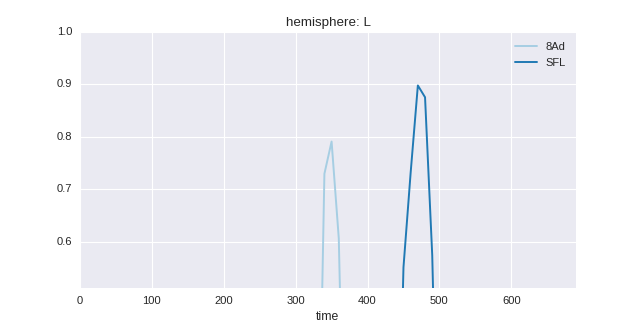

<IPython.core.display.Javascript object>


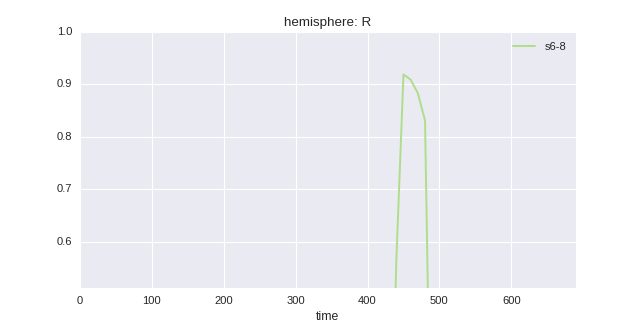

In [14]:
print(r_name)

region = 'dorso'

sv.show_timecourses(get_cluster_tcs(r_clusters[r_clusters.region.apply(lambda s: s.startswith(region))]), 
                    [threshold, ylims[measure]], logy=logy[measure])

### clusters associated with a particular area

In [ ]:
print(r_name)

# put the full area name in underscores such as '_1_' to match exactly
area = '_VMV1_'

sv.show_timecourses(get_cluster_tcs(r_clusters[r_clusters.label.apply(lambda s: s.find(area)>0)]), 
                    [threshold, ylims[measure]], logy=logy[measure])

### clusters with reliable effect around a particular time

dot_x


<IPython.core.display.Javascript object>


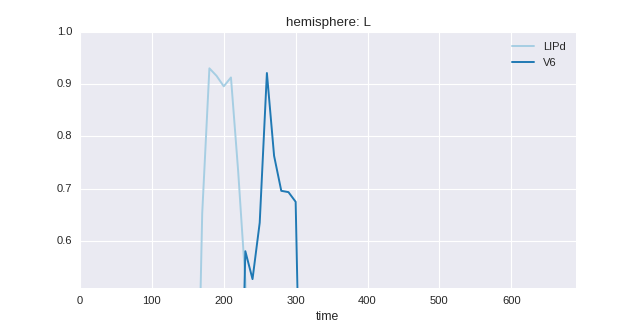

<IPython.core.display.Javascript object>


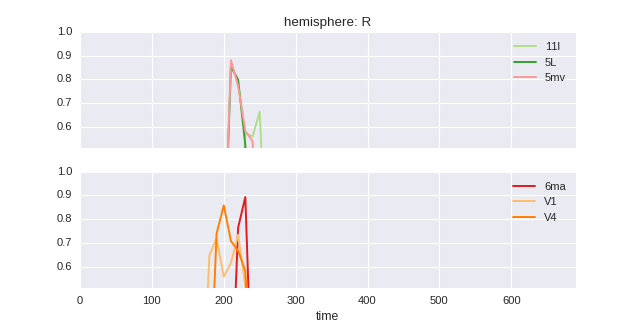

In [15]:
print(r_name)

time = 230

sv.show_timecourses(get_cluster_tcs(r_clusters[(time >= r_clusters.start_t) & (time <= r_clusters.end_t)]), 
                    [threshold, ylims[measure]], logy=logy[measure])

## Investigate consistency

In [15]:
src_df.loc[('L_8Ad_ROI-lh', 350)]

mu_mean         0.024773
mu_std          0.006247
mu_t            3.965776
mu_testval      0.001365
mu_p_large      0.791000
sigma_mean      0.024500
sigma_std       0.005728
theta_mean      0.802082
theta_std       0.102769
lp_mean        61.247414
lp_std          1.619361
overlap        -1.858091
consistency     0.691500
Name: (L_8Ad_ROI-lh, 350), dtype: float64

In [16]:
for cl in r_clusters.itertuples():
    r_clusters.loc[cl.Index, 'mean_consistency'] = (
        src_df.loc[(cl.label, slice(cl.start_t, cl.end_t)), 'consistency'].mean())
    r_clusters.loc[cl.Index, 'max_consistency'] = (
        src_df.loc[(cl.label, slice(cl.start_t, cl.end_t)), 'consistency'].max())

r_clusters[r_clusters.max_consistency < 0.5].sort_values('start_t')

,label,start_t,end_t,log10p,pval_corrected,region,mean_consistency,max_consistency
cluster,,,,,,,,
95,L_52_ROI-lh,180,190,-4.736629,0.000198,insular and frontal opercular cortex,0.043000,0.0580
475,L_a32pr_ROI-lh,300,320,-5.077124,0.000100,anterior cingulate and medial prefrontal cortex,0.288667,0.3830
724,R_EC_ROI-rh,490,510,-4.929821,0.000136,medial temporal cortex,0.168167,0.2185
772,R_LBelt_ROI-rh,510,530,-4.513193,0.000307,early auditory cortex,0.306667,0.4055
511,L_s32_ROI-lh,540,570,-5.967600,0.000015,anterior cingulate and medial prefrontal cortex,0.317125,0.3680
709,R_AIP_ROI-rh,570,580,-3.978405,0.000918,superior parietal cortex,0.082500,0.1410
335,L_POS2_ROI-lh,640,660,-4.692268,0.000213,posterior cingulate cortex,0.401667,0.4380
